<a href="https://colab.research.google.com/github/sidle34/allofthestuff/blob/Notebooks/SepsisAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

The data being analyzed is released by the National Center for Health
Statistics which is a branch of the Center for Disease Control (CDC). I have
chosen to use the inpatient dataset from the 2021 National Hospital Care Survey (NHCS).  

[NHCS Questionnaires, Datasets, and Documentation | NHCS | CDC](https://www.cdc.gov/nchs/nhcs/data/index.html)

Patient-level data is provided to NHCS via transfer of electronic health records, standardized medical claim forms (called UB-04 forms), or a copy of a similar file sent to the state health department. Therefore, NHCS does not use questionnaires to collect these data.  

My hypothesis is adult patients with a recorded primary diagnosis of sepsis are at a significantly higher risk of mortality when complicated by respiratory failure compared to patients without respiratory failure. I would also like to explore what other variables are significant in predicting mortality in adult patients aged 18+.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nhcs2021ip_sas.sas7bdat to nhcs2021ip_sas.sas7bdat


In [ ]:
survey = pd.read_sas('nhcs2021ip_sas.sas7bdat', format='sas7bdat')

#Preview the data
print(survey.head())

        PUF_ID     YEAR   AGE  SEX  NEWBORN  LOS  LOS_30DAYS  DISCHARGE_MONTH  \
0  b'21000001'  b'2021'  62.0  1.0      2.0  3.0         2.0              2.0   
1  b'21000002'  b'2021'   3.0  1.0      2.0  1.0         2.0              1.0   
2  b'21000003'  b'2021'  61.0  1.0      2.0  3.0         2.0              7.0   
3  b'21000004'  b'2021'  64.0  1.0      2.0  9.0         2.0             11.0   
4  b'21000005'  b'2021'  26.0  2.0      2.0  1.0         2.0             10.0   

   DISCHARGE_STATUS     PD1  ... PUF_ENCWGT_121 PUF_ENCWGT_122 PUF_ENCWGT_123  \
0               1.0  b'0MB'  ...      34.765423      34.765423      34.765423   
1               1.0  b'4A1'  ...      37.576165      37.576165      37.576165   
2               1.0  b'0W9'  ...      45.675972      45.675972      45.675972   
3               1.0  b'0BD'  ...      32.445466      32.445466      32.445466   
4               1.0  b'10E'  ...     368.324655     368.324655     368.324655   

  PUF_ENCWGT_124 PUF_ENCWG

# From an initial preview of the data, sepsis is the third leading primary diagnosis.

In [ ]:
survey['DX1'] = survey['DX1'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

counts = survey['DX1'].value_counts()
print(counts)

DX1
Z380    16460
U071     5702
A419     5598
-9       5165
I130     2529
        ...  
A549        1
Q789        1
N269        1
H831        1
L280        1
Name: count, Length: 4211, dtype: int64


In [ ]:
#Total observations in the survey
print(len(survey))

#Filter for adult patients
adults = survey[survey['AGE'] >= 18]
print(len(adults))

#Filter for sepsis diagnosis
sepsis_DX = ['A021','A207','A217','A227','A241','A267','A282','A321','A327','A392',
          'A393','A394','A400','A401','A402','A403','A404','A405','A406','A407',
          'A408','A409','A410','A411','A412','A413','A414','A415','A418','A419',
          'A427','A548','B007','B377','O033','O038','O048','0O73','O088','O753',
          'O850','O860','P360','P361','R652','T802','T814','T880']

#Only include observations with sepsis diagnosis as DX1
sepsis = adults[adults['DX1'].isin(sepsis_DX)]
print(len(sepsis))

179026
150961
10593


# In 2021, 84% of all hospital inpatient encounters were adults. Of those encounters, 7% had a primary diagnosis of sepsis.

***DISCHARGE_STATUS Variable***  
Patient discharged the hospital deceased  
1 = Yes  
2 = No

In [ ]:
# Drop rows where DISCHARGE_STATUS is -9 (unknown)
sepsis_DC = sepsis[sepsis['DISCHARGE_STATUS'] != -9].copy()

# Recode values: 1-7 as 2 (alive), 8 as 1 (deceased)
sepsis_DC['DISCHARGE_STATUS'] = sepsis_DC['DISCHARGE_STATUS'].apply(
    lambda x: 2 if 1 <= x <= 7 else (1 if x == 8 else x))

In [ ]:
count_dc = sepsis_DC['DISCHARGE_STATUS'].value_counts()
print(count_dc)

DISCHARGE_STATUS
2    9368
1    1216
Name: count, dtype: int64


# 11.5% of adult patients with a primary diagnosis of sepsis during a hospital inpatient encounter in 2021 died.

In [ ]:
# Remove missing variables
sepsis_DC = sepsis_DC[sepsis_DC['AGE'] != -9].copy()
print(len(sepsis))

10593


***Sex Variable***  
1 = Male  
2 = Female

In [ ]:
# Remove missing variables
sepsis_DC = sepsis_DC[sepsis_DC['SEX'] != -9].copy()
print(len(sepsis))

10593


In [ ]:
count_sex = sepsis_DC['SEX'].value_counts()
print(count_sex)

SEX
1.0    5449
2.0    5134
Name: count, dtype: int64


***CCSR_RSP012 Variable***  
Patient had a diagnosis of respiratory failure  
1 = Yes  
2 = No

In [ ]:
#1=Respiratory Failure; 2=None
count_rf = sepsis['CCSR_RSP012'].value_counts()
print(count_rf)

CCSR_RSP012
2.0    6577
1.0    4016
Name: count, dtype: int64


***DX_GT30 Variable***  
Patient has 31 or more diagnoses  
1 = Yes  
2 = No

In [ ]:
#1=31 or more diagnoses; 2=30 or less diagnoses
count_gt30 = sepsis['DX_GT30'].value_counts()
print(count_gt30)

DX_GT30
2.0    9224
1.0    1369
Name: count, dtype: int64


***LOS_30DAYS Variable***  
Patient had a length of stay greater than 30 days  
1 = Yes  
2 = No


In [ ]:
#1=Length of stay greater than or equal to 30 days; 2=Length of stay less than 30 days
count_los = sepsis_DC['LOS_30DAYS'].value_counts()
print(count_los)

LOS_30DAYS
2.0    10146
1.0      438
Name: count, dtype: int64


In [ ]:
#Convert variables to factors
sepsis_DC['DISCHARGE_STATUS'] = sepsis_DC['DISCHARGE_STATUS'].astype('category')
sepsis_DC['CCSR_RSP012'] = sepsis_DC['CCSR_RSP012'].astype('category')
sepsis_DC['DX_GT30'] = sepsis_DC['DX_GT30'].astype('category')
sepsis_DC['LOS_30DAYS'] = sepsis_DC['LOS_30DAYS'].astype('category')
sepsis_DC['SEX'] = sepsis_DC['SEX'].astype('category')

# Analyzing the data utilizing a logistic regression model.

In [ ]:
#Split data into features and target
lrX = sepsis_DC[['DX_GT30', 'CCSR_RSP012', 'LOS_30DAYS', 'SEX']]
lry = sepsis_DC['DISCHARGE_STATUS']

# Random oversampling
ros = RandomOverSampler(random_state=42)
lrX_resampled, lry_resampled = ros.fit_resample(lrX, lry)


#Split into training and testing sets
lrX_train, lrX_test, lry_train, lry_test = train_test_split(lrX_resampled, lry_resampled, test_size=0.2, random_state=42)

#Train logistic regression model
lrmodel = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
lrmodel.fit(lrX_train, lry_train)

#Predict values and evaluate model
lry_pred = lrmodel.predict(lrX_test)
lraccuracy = accuracy_score(lry_test, lry_pred)

# Predict probabilities
lry_prob = lrmodel.predict_proba(lrX_test)[:, 1]

#Output model coefficients and accuracy
lrcoefficients = dict(zip(lrX.columns, lrmodel.coef_[0]))
lrintercept = lrmodel.intercept_[0]
lrreport = classification_report(lry_test, lry_pred)
lrroc_auc = roc_auc_score(lry_test, lry_pred)

#Create coefficients table
coeff_table = pd.DataFrame(list(lrcoefficients.items()), columns=['Feature', 'Coefficient'])

#Print results
print("Model Coefficients:\n", coeff_table)
print("Intercept:", lrintercept)
print("Accuracy on test set:", lraccuracy)
print("ROC AUC Score:", lrroc_auc)
print("Classification Report:\n", lrreport)

Model Coefficients:
        Feature  Coefficient
0      DX_GT30     0.583606
1  CCSR_RSP012     2.233696
2   LOS_30DAYS     0.195332
3          SEX     0.152018
4          AGE    -0.024479
Intercept: -3.2180825410395966
Accuracy on test set: 0.7542689434364994
ROC AUC Score: 0.7551889613533449
Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.83      0.77      1850
           2       0.80      0.68      0.74      1898

    accuracy                           0.75      3748
   macro avg       0.76      0.76      0.75      3748
weighted avg       0.76      0.75      0.75      3748



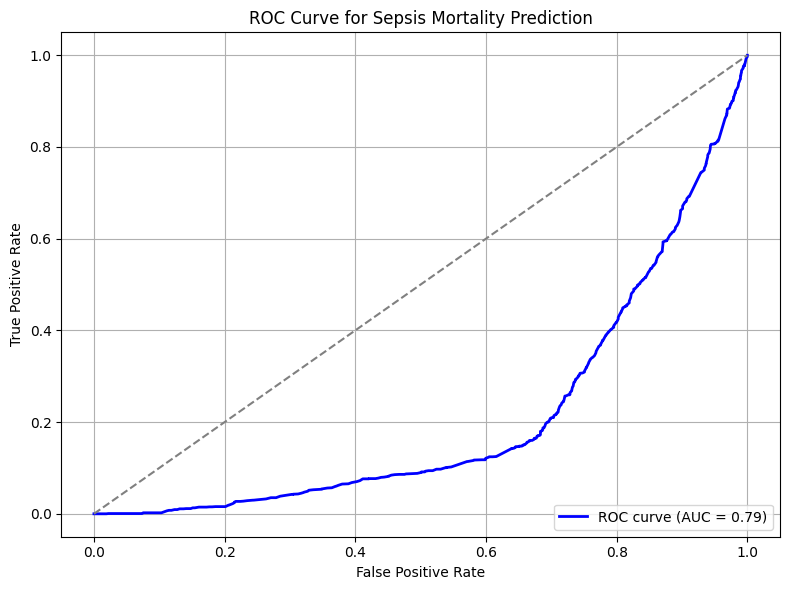

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(lry_test, lry_prob, pos_label=1)
roc_auc = roc_auc_score(lry_test, lry_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sepsis Mortality Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



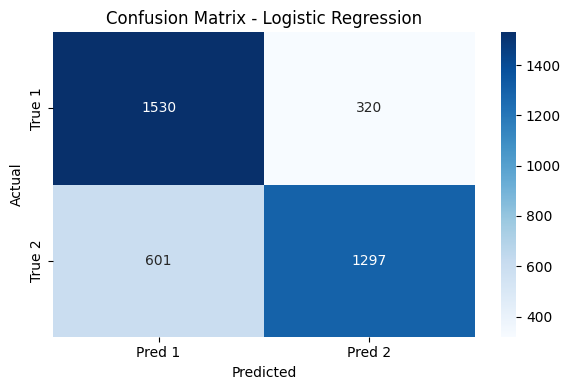

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(lry_test, lry_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 1', 'Pred 2'],
            yticklabels=['True 1', 'True 2'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Based on this output, having greater than 30 diagnoses and a long length of stay increases the odds of death when sepsis is the primary diagnosis. Male patients also have slightly higher odds of mortality. Having a diagnosis of respiratory failure in conjunction with a primary diagnosis of sepsis is the highest predictor of mortality. Older patients actually have lower odds of mortality. When no other features are present in a sepsis patient, there is a lower probability of mortality. By random oversampling the data to account for the imbalance, the accuracy of this model is 75.4%.

# Analyzing the data utilizing a random forest model

In [ ]:
#Split data into features and target
rfX = sepsis_DC[['DX_GT30', 'CCSR_RSP012', 'LOS_30DAYS', 'SEX']]
rfy = sepsis_DC['DISCHARGE_STATUS']

# Random oversampling
ros = RandomOverSampler(random_state=42)
rfX_resampled, rfy_resampled = ros.fit_resample(rfX, rfy)

#Split into training and testing sets
rfX_train, rfX_test, rfy_train, rfy_test = train_test_split(rfX_resampled, rfy_resampled, test_size=0.2, random_state=35)

#Set up parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

#Set up the model and GridSearchCV
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    refit=False
)

#Fit the model
grid_search.fit(rfX_train, rfy_train)

#Print results for identified hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
#Retrain the model on the full training set using the best parameters
best_params = grid_search.best_params_
sepsis_best_rf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
sepsis_best_rf.fit(rfX_train, rfy_train)

#Measure performance on the test set
rfy_pred = sepsis_best_rf.predict(rfX_test)

#Print accuracy results and classification report
sepsis_report = classification_report(rfy_test, rfy_pred)
sepsis_final_accuracy = accuracy_score(rfy_test, rfy_pred)
print("Accuracy with Best Parameters:", sepsis_final_accuracy)
print("Classification Report:\n", sepsis_report)

Accuracy with Best Parameters: 0.7724119530416222
Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.82      0.78      1877
           2       0.80      0.72      0.76      1871

    accuracy                           0.77      3748
   macro avg       0.77      0.77      0.77      3748
weighted avg       0.77      0.77      0.77      3748



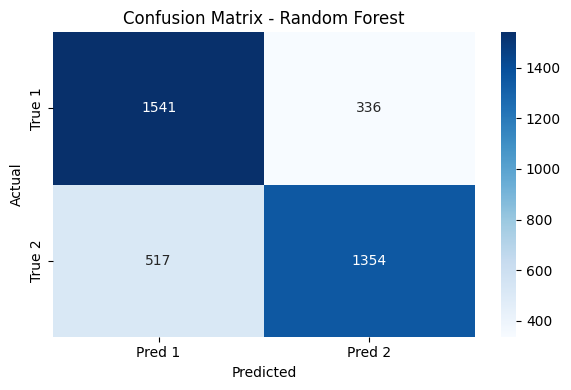

In [ ]:
#Generate confusion matrix
cm = confusion_matrix(rfy_test, rfy_pred)

#Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 1', 'Pred 2'],
            yticklabels=['True 1', 'True 2'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

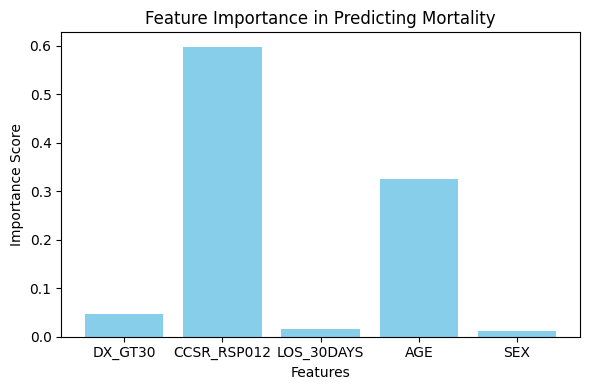

In [ ]:
#Get feature importances
importances = sepsis_best_rf.feature_importances_
feature_names = rfX.columns

#Create a bar plot for feature importances
plt.figure(figsize=(6, 4))
plt.bar(feature_names, importances, color='skyblue')
plt.title('Feature Importance in Predicting Mortality')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()


Having a diagnosis of respiratory failure with a primary diagnosis of sepsis is the most important factor in mortality of hospitalized adult patients in 2021, followed by age. Utilizing random oversampling to account for the unbalanced data, this model had an accuracy of 77.2%

The sample size was very skewed, with a very small sample of deaths compared to live discharges. Thus, random oversampling was used in an attempt to balance the data for both of the models and obtain a higher accuracy rating.

# Based on these models, we would reject the null hypothesis: adults in 2021 that were admitted to the hospital with a primary diagnosis of sepsis had significantly higher odds of mortality when a secondary diagnosis of respiratory failure was present.